## GTEx V8 eqtldata download from GTEx
#### Lead (SNPs with the most statistically significant changes in each tissue), 
#### Causal (SNPs showing causal relationship with gene expression when screened by CaVEMaN, a computational model)
#### TF (SNPs residing in any binding site of 655 transcription factors)
#### Nominal (all SNPs with statistically significant changes)

## Transcript factor in K562 and HepG2 cells data get and merge
##### The TF factor dataset were download from encode data, the TFs and smaples info can be see on supplementary table 1

In [4]:
# -*- coding: utf-8 -*- 
# @Time : 2021/9/9 10:45 
# @Author : guangyuel
# @File : gat-run_encode_chip_seq_analysis.py

import os
import sys
import pandas as pd
import numpy as np
import pyranges as pr
from scipy import stats
import logging
import pyranges as pr
import warnings
# stats.hypergeom.sf()
warnings.filterwarnings('ignore')

def file_check(path):
    if not os.path.isfile(path):
        log().error("{file} is not exist !!!".format(file=path))
        sys.exit(1)

def myMkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
def log():
    logger = logging.getLogger("encode_analysis")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger


if __name__== "__main__":
    logger = log()

    data_path = "/disk2/G4_MS/encode/data/TF"
    wdpath = "/disk2/G4_MS/encode/analysis/TF"
    os.chdir(wdpath)
    chip_meta = os.path.join(data_path,"metadata.tsv")
    df = pd.read_table(chip_meta)
    df = df.loc[:,['File accession',"Experiment target",'Biosample term name']]
    df.loc[:,"Experiment target"] = df.loc[:,"Experiment target"].map(lambda x:x.split("-")[0])
#     df['Experiment target'] = df["Target gene symbol"]
    df["keys"] = df.apply(lambda x: x["Experiment target"] + "_" + x["Biosample term name"], axis=1)
    df = df.iloc[:,[0,3]]
    tmp = []
    for id, group in df.groupby("keys"):
        group = group.reset_index(drop=True)
        group.reset_index(inplace=True)
        group["keys"] = group.apply(lambda x: x["keys"] + "_0" + str(x["index"] + 1), axis=1)
        tmp.append(group)
    df = pd.concat(tmp).iloc[:,[1,2]]
    chip_paths = {}
    for index,line in df.iterrows():
        chip_paths[line["keys"]] = os.path.join(data_path, line["File accession"]+".bed.gz")
    del tmp, df
    idr_throad = 540
    chip_results = []
    for k, p in chip_paths.items():
        df = pd.read_table(p,compression="gzip",header=None)
        df = df[df[4] >= idr_throad]
        df = df.iloc[:, [0,1,2,3,4]]
        df[5] = k
        chip_results.append(df)
    df = pd.concat(chip_results)
    df.to_csv(os.path.join(wdpath,"k562_hepG2_encode_TF.bed"),sep="\t",header=False,index=False)
    logger.info("chip_seq data prepared done")
    del df
    df = pd.read_table(os.path.join(wdpath,"k562_hepG2_encode_TF.bed"),names=["Chromosome","Start","End","Strand","value","Class"])
    df.loc[:,"Target"]=df.Class.map(lambda x:x.split("_")[0])
    df.loc[:,"Cell"] = df.Class.map(lambda x:x.split("_")[1])
    df = df.loc[:,["Chromosome","Start","End","Target","Cell"]]
    tss_promoter= pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter.annotion.tsv"))
    tss_G4 = pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_pG4.info.tsv"))
    e_promoter= pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_info.annotion.H3K4me3.tsv"))
    eG4 = pr.PyRanges(pd.read_table("/disk2/project/g_quadruplex/promoter_select/promoter_info/promoter_pG4.info.H3K4me3.tsv"))

    myMkdir(os.path.join(wdpath,"Tss_HepG2"))
    myMkdir(os.path.join(wdpath,"Tss_K562"))
    myMkdir(os.path.join(wdpath,"h3k4me3_HepG2"))
    myMkdir(os.path.join(wdpath,"h3k4me3_K562"))
    myMkdir(os.path.join(wdpath,"HepG2"))
    myMkdir(os.path.join(wdpath,"K562"))
    for index,pdf in df.groupby(["Cell","Target"]):
        tmp = pr.PyRanges(pd.DataFrame(pdf)).merge()
        tmp.Name = index[1]
        tmp.Score = index[0]
        tmp.Strand = "."
        tmp.to_bed(os.path.join(wdpath,index[0],"_".join(index)+".bed"))
        tss_tmp = tmp.overlap(tss_promoter)
        tss_tmp.to_bed(os.path.join(wdpath,"Tss_"+index[0],"_".join(index)+".bed"))
        h3k4me3_tmp = tmp.overlap(e_promoter)
        h3k4me3_tmp.to_bed(os.path.join(wdpath,"h3k4me3_"+index[0],"_".join(index)+".bed"))
    

23-03-25 18:55:45 encode_analysis INFO chip_seq data prepared done


## *cis*-eQTLs data prepared 

In [6]:
%load_ext rpy2.ipython

In [2]:
# data_get.py
import os
import gzip
import pyranges as pr
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

def myMkdir(path):
    try:
        if not os.path.exists(path):
            os.mkdir(path)
    except FileNotFoundError:
        print("generated more than one layer path")
        os.makedirs(path)
class LevEQTLS():
    def __init__(self,filepath):
        self.filepath = filepath
        self.name = os.path.basename(self.filepath).split(".")[0]
    def levGet(self):
        self.df = pd.read_table(self.filepath,compression="gzip")
        self.nominal = self.df.copy(deep=True)
        self.nominal["Chromosome"],self.nominal["Start"],self.nominal["Ref"],self.nominal["Alt"],self.nominal["genomic_class"] = self.nominal.variant_id.str.split("_").str
        self.nominal.loc[:,"End"] = self.nominal.apply(lambda x:int(x.Start)+len(x.Ref),axis=1)
        self.nominal = self.nominal.loc[:,["Chromosome","Start","End","Ref","Alt","gene_id","tss_distance","ma_samples","ma_count","pval_nominal","slope","slope_se","pval_nominal_threshold","min_pval_nominal","pval_beta"]]
        self.nominal.loc[:,"Tissue"] = self.name
        self.df = self.df[self.df.index.isin(self.df.groupby("gene_id").pval_nominal.idxmin())]
        self.df["Chromosome"],self.df["Start"],self.df["Ref"],self.df["Alt"],self.df["genomic_class"] = self.df.variant_id.str.split("_").str
        self.df.loc[:,"End"] = self.df.apply(lambda x:int(x.Start)+len(x.Ref),axis=1)
        self.df = self.df.loc[:,["Chromosome","Start","End","Ref","Alt","gene_id","tss_distance","ma_samples","ma_count","pval_nominal","slope","slope_se","pval_nominal_threshold","min_pval_nominal","pval_beta"]]
        self.df.loc[:,"Tissue"] = self.name
        
wd_path = "/disk2/G4_MS/eQTL/data"
filepaths = [p for p in os.listdir(os.path.join(wd_path,"GTEx_Analysis_v8_eQTL")) if p.endswith(".signif_variant_gene_pairs.txt.gz")]
all_df = []
nominal_df = []
for p in filepaths:
    lev = LevEQTLS(os.path.join(wd_path,"GTEx_Analysis_v8_eQTL",p))
    lev.levGet()
    all_df.append(lev.df)
    nominal_df.append(lev.nominal)
df = pd.concat(all_df)
df.to_csv(os.path.join(wd_path,"lev.per.gene.tsv"),sep="\t",index=False)
del df
nominal = pd.concat(nominal_df)
nominal.to_csv(os.path.join(wd_path,"nominally.per.gene.tsv.gz"),sep="\t",index=False,compression="gzip")

In [ ]:
# causal data get
import pandas as pd
import gzip
import os
wdpath = "/disk2/G4_MS/eQTL/data"
causal_path = os.path.join(wdpath,"GTEx_v8_finemapping_CaVEMaN","GTEx_v8_finemapping_CaVEMaN.txt.gz")
causal = pd.read_table(causal_path,compression="gzip")
causal = causal.loc[:,["TISSUE","GENE","eQTL","Probability"]]
causal["Chromosome"],causal["Start"],causal["Ref"],causal["Alt"] = causal.eQTL.str.split("_").str
causal = causal.drop_duplicates()
causal.loc[:,"End"] = causal.apply(lambda x:int(x.Start)+len(x.Ref),axis=1)
causal = causal.loc[:,["Chromosome","Start","End","Ref","Alt","GENE","TISSUE"]]
nominal = pd.read_table(os.path.join(wdpath,"nominally.per.gene.tsv.gz"),compression="gzip")
nominal.loc[:,"key"] = nominal.apply(lambda x:str(x.Chromosome)+"_"+str(x.Start)+"_"+str(x.End)+"_"+str(x.Ref)+"_"+str(x.Alt),axis = 1)
causal.loc[:,"key"] = causal.apply(lambda x:str(x.Chromosome)+"_"+str(x.Start)+"_"+str(x.End)+"_"+str(x.Ref)+"_"+str(x.Alt),axis = 1)
causal =  nominal[nominal.key.isin(causal.key)]
causal = causal.drop_duplicates()
causal = causal.loc[:,['Chromosome', 'Start', 'End', 'Ref', 'Alt', 'gene_id', 'tss_distance', 'ma_samples', 'ma_count', 'pval_nominal', 'slope', 'slope_se',
       'pval_nominal_threshold', 'min_pval_nominal', 'pval_beta', 'Tissue']]
causal.to_csv(os.path.join(wdpath,"causal.eqtls.info.tsv.gz"),sep="\t",index=False,compression="gzip")

### TF intersection site were download from ENCODE, and using python costom script to merge all TF peaks. the TF infoamtion were obtain from Supplementary Table 1

In [ ]:
# TF_eqtls get
import pandas as pd
import pyranges as pr
chip_path = "/disk2/G4_MS/encode/analysis/TF/k562_hepG2_encode_TF.bed"
chip = pr.PyRanges(pd.read_table(chip_path,header=None,names=["Chromosome","Start","End","Strand","Score","Name"]))
nominal = pr.PyRanges(pd.read_table("/disk2/G4_MS/eQTL/data/nominally.per.gene.tsv.gz",compression="gzip"))
chip_eqtl = nominal.overlap(chip.merge(),strandedness = False)
chip_eqtl.to_csv("/disk2/G4_MS/eQTL/data/TF.eqtls.info.tsv.gz",compression="gzip",sep="\t")

In [ ]:
# all snp get
import os
import pandas as pd

data_path = "/disk2/G4_MS/eQTL/data/WGS_Feature_overlap_collapsed_VEP_short_4torus.MAF01.txt.gz"
df = pd.read_table(data_path,compression="gzip")
# df = df.loc[:,"SNP"]
df["Chromosome"],df["Start"],df["Ref"],df["Alt"],df["reference"] = df.SNP.str.split("_").str
df.loc[:,"End"] = df.apply(lambda x:int(x.Start)+len(x.Ref),axis=1)
df = df.loc[:,["Chromosome","Start","End","Ref","Alt","reference"]]
df.to_csv("/disk2/G4_MS/eQTL/data/GTEx_Analysis_v8_all.snp.MAF001.bed.gz",sep="\t",index=False,compression="gzip")

### eQTls_analysis 
#### Fig 6a 

In [ ]:
# eqtl noG4
import pyranges as pr
import pandas as pd
import numpy as np
import os
import gzip
import logging
import warnings

warnings.filterwarnings("ignore")


def file_check(path):
    if not os.path.isfile(path):
        log().error("{file} is not exist !!!".format(file=path))
        sys.exit(1)
        
def log():
    logger = logging.getLogger("eQTL")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger

class AFC_get():
    def __init__(self,pG4path,promoter_path,eqtl_path):
        self.pG4_path = pG4path
        self.promoter_path = promoter_path
        self.eqtl_path = eqtl_path
    def gene_id_filter(self,cds):
        ## differenter regions of promoter identified 
        self.promoter = pr.PyRanges(pd.read_table(self.promoter_path)).subtract(cds, strandedness=False).subset(lambda df:df.Chromosome != "chrY")
        self.pG4 = pr.PyRanges(pd.read_table(self.pG4_path)).subtract(cds, strandedness=False).subset(lambda df:df.Chromosome != "chrY")
        self.non_pG4 = self.promoter[self.promoter.transcript_id.isin(self.pG4.transcript_id)].subtract(self.pG4,strandedness=False).subtract(cds,strandedness=False)
#         self.pG4_merge = self.pG4.merge()
#         self.pG4_length = self.pG4_merge.length/self.pG4_merge.__len__()        
#         self.non_pG4 = self.promoter[self.promoter.transcript_id.isin(self.pG4.transcript_id)].subtract(self.pG4,strandedness=False).subtract(cds,strandedness=False)
#         self.promoter = self.promoter[['Chromosome', 'Start', 'End', 'Promoter_id', 'gene_id', 'Strand', 'gene_type', 'gene_name']]
#         self.non_pG4_select = self.promoter.overlap(self.non_pG4.window(self.pG4_length).sample(self.pG4_merge.__len__()))
#         self.pG4_select = self.promoter.overlap(self.pG4_merge)
        
        self.pG4.transcript_id = self.pG4.transcript_id.map(lambda x:x.split(".")[0])
        self.pG4.gene_id = self.pG4.gene_id.map(lambda x:x.split(".")[0])

        ## non G4 
        self.non_pG4.transcript_id = self.non_pG4.transcript_id.map(lambda x:x.split(".")[0])
        self.non_pG4.gene_id = self.non_pG4.gene_id.map(lambda x:x.split(".")[0])
        ## eqtl
        self.eqtl = pr.PyRanges(pd.read_table(self.eqtl_path))
        self.eqtl.gene_id = self.eqtl.gene_id.map(lambda x:x.split(".")[0])
        ####
#         overlap_gene_id = set(self.eqtl.gene_id).intersection(set(list(self.pG4.gene_id)+list(self.non_pG4.gene_id)))
#         self.eqtl = self.eqtl[self.eqtl.gene_id.isin(overlap_gene_id)]
#         self.pG4 = self.pG4[self.pG4.gene_id.isin(overlap_gene_id)]
        self.pG4_stable = self.pG4[self.pG4.Score > 19]
        self.pG4_unstable = self.pG4[self.pG4.Score <= 19]
#         self.nonpG4 = self.non_pG4[self.non_pG4.gene_id.isin(overlap_gene_id)]
        
    def eQTL(self, all_snp, non_pG4=False):
        if not non_pG4:
            non_pG4 = self.non_pG4
        pG4_eqtl = self.eqtl.join(self.pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl = pG4_eqtl[pG4_eqtl.gene_id==pG4_eqtl.gene_id_c]
        non_pG4_eqtl = self.eqtl.join(non_pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
        non_pG4_eqtl = non_pG4_eqtl[non_pG4_eqtl.gene_id==non_pG4_eqtl.gene_id_c]
        pG4_bg = all_snp.join(self.pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
#         pG4_bg = pG4_bg.overlap(self.eqtl,strandedness = False,invert=True)
        non_pG4_bg = all_snp.overlap(non_pG4,strandedness=False)
#         non_pG4_bg = non_pG4_bg.overlap(self.eqtl,strandedness = False,invert=True)
        self.result = np.array([pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                pG4_bg.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_bg.drop_duplicate_positions(strand=False).__len__()
                               ]
                              )
        
        pG4_eqtl_stable = self.eqtl.join(self.pG4_stable,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_stable = pG4_eqtl_stable[pG4_eqtl_stable.gene_id==pG4_eqtl_stable.gene_id_c]
        pG4_bg_stable = all_snp.join(self.pG4_stable,strandedness = False,apply_strand_suffix=False,suffix="_c")
#         pG4_bg_stable = pG4_bg_stable.overlap(self.eqtl,strandedness = False,invert=True)
        self.stable_result = np.array([pG4_eqtl_stable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                pG4_bg_stable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_bg.drop_duplicate_positions(strand=False).__len__()
                               ]
                              )
        pG4_eqtl_unstable = self.eqtl.join(self.pG4_unstable,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_unstable = pG4_eqtl_unstable[pG4_eqtl_unstable.gene_id==pG4_eqtl_unstable.gene_id_c]
        pG4_bg_unstable = all_snp.join(self.pG4_unstable,strandedness = False,apply_strand_suffix=False,suffix="_c")
#         pG4_bg_unstable = pG4_bg_unstable.overlap(self.eqtl,strandedness = False,invert=True)
        self.unstable_result = np.array([pG4_eqtl_unstable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                pG4_bg_unstable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_bg.drop_duplicate_positions(strand=False).__len__()
                               ]
                              )

        

#### 
logger = log()
data_path = "/disk2/G4_MS/eQTL/data"
wdpath = "/disk2/G4_MS/eQTL"
logger.info("TSS Start")
promoter_path = os.path.join(os.path.dirname(wdpath),"promoter_select","promoter_info")
tss_promoter_path = os.path.join(promoter_path,"promoter.annotion.tsv")
tss_pG4_path = os.path.join(promoter_path,"promoter_pG4.info.tsv")
# tss_nonPG4_path = os.path.join(promoter_path,"promoter_nopG4.info.tsv")
h3k4me3_promoter_path = os.path.join(promoter_path,"promoter_info.annotion.H3K4me3.tsv")
h3k4me3_G4_path = os.path.join(promoter_path,"promoter_pG4.info.H3K4me3.tsv")
# hek4me4_nonG4_path = os.path.join(promoter_path,"promoter_nopG4.info.H3K4me3.tsv")
cds_path = os.path.join(data_path,"cds.bed")
## eqtl path
lev_eqtl = os.path.join(data_path,"lev.per.gene.tsv.gz")
nominally_eqtl = os.path.join(data_path,"nominally.per.gene.tsv.gz")
causal_eqtl = os.path.join(data_path,"causal.eqtls.info.tsv.gz")
tf_eqtl = os.path.join(data_path,"TF.eqtls.info.tsv.gz")

# all_snp_path = os.path.join(data_path,"GTEx_Analysis_v8_all.snp.bed.gz")
all_snp_path = os.path.join(data_path,"GTEx_Analysis_v8_all.snp.MAF001.bed.gz")
all_snp = pr.PyRanges(pd.read_table(all_snp_path,compression="gzip"))
all_snp = all_snp.overlap(pr.PyRanges(pd.read_table(nominally_eqtl)),invert=True)
# all_snp = pr.PyRanges(pd.read_table(all_snp_path,compression="gzip",header=None,names=["Chromosome","Start","End","Ref","Alt","variiation_id", "Variation_numbers","Rs_id","b37_varition_id"]))
cds = pr.read_bed(cds_path)

################ TSS analysis
logger.info("TSS pG4 result get")
# lev 
tss = AFC_get(tss_pG4_path,tss_promoter_path,lev_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp)
lev_result = tss.result.copy()
lev_stable_result = tss.stable_result.copy()
lev_unstable_result = tss.unstable_result.copy()
print(tss.non_pG4)
del tss
# causal 
tss = AFC_get(tss_pG4_path,tss_promoter_path,causal_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp)
causal_result = tss.result.copy()
causal_stable_result = tss.stable_result.copy()
causal_unstable_result = tss.unstable_result.copy()
del tss

# TF 
tss = AFC_get(tss_pG4_path,tss_promoter_path,tf_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp)
TF_result = tss.result.copy()
TF_stable_result = tss.stable_result.copy()
TF_unstable_result = tss.unstable_result.copy()
del tss

# nominal 
tss = AFC_get(tss_pG4_path,tss_promoter_path,nominally_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp)
nominal_result = tss.result.copy()
nominal_stable_result = tss.stable_result.copy()
nominal_unstable_result = tss.unstable_result.copy()
# del tss

# del tss 

tss_result = pd.DataFrame([lev_result, causal_result, nominal_result, TF_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
tss_result.to_csv(os.path.join(wdpath,"tss_pG4.eqtl.result.csv"))

tss_stable_result = pd.DataFrame([lev_stable_result, causal_stable_result, nominal_stable_result,TF_stable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
tss_stable_result.to_csv(os.path.join(wdpath,"tss_pG4_stable.eqtl.result.csv"))

tss_unstable_result = pd.DataFrame([lev_unstable_result, causal_unstable_result, nominal_unstable_result,TF_unstable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
tss_unstable_result.to_csv(os.path.join(wdpath,"tss_pG4_unstable.eqtl.result.csv"))

logger.info("TSS pG4 result DONE")

################ H3K4me3 analysis
logger.info("H3K4me3 pG4 result get")
# lev 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,lev_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,non_pG4=tss.non_pG4)
ep_lev_result = ep.result.copy()
ep_lev_stable_result = ep.stable_result.copy()
ep_lev_unstable_result = ep.unstable_result.copy()
del ep
# causal 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,causal_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,non_pG4=tss.non_pG4)
ep_causal_result = ep.result.copy()
ep_causal_stable_result = ep.stable_result.copy()
ep_causal_unstable_result = ep.unstable_result.copy()
del ep

# nominal 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,nominally_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,non_pG4=tss.non_pG4)
ep_nominal_result = ep.result.copy()
ep_nominal_stable_result = ep.stable_result.copy()
ep_nominal_unstable_result = ep.unstable_result.copy()
del ep
# TF 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,tf_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,non_pG4=tss.non_pG4)
ep_TF_result = ep.result.copy()
ep_TF_stable_result = ep.stable_result.copy()
ep_TF_unstable_result = ep.unstable_result.copy()
del ep 

ep_result = pd.DataFrame([ep_lev_result, ep_causal_result, ep_nominal_result,ep_TF_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
ep_result.to_csv(os.path.join(wdpath,"H3k4me3_pG4.eqtl.result.csv"))

ep_stable_result = pd.DataFrame([ep_lev_stable_result, ep_causal_stable_result, ep_nominal_stable_result,ep_TF_stable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
ep_stable_result.to_csv(os.path.join(wdpath,"H3k4me3_pG4.eqtl_stable.result.csv"))

ep_unstable_result = pd.DataFrame([ep_lev_unstable_result, ep_causal_unstable_result, ep_nominal_unstable_result,ep_TF_unstable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
ep_unstable_result.to_csv(os.path.join(wdpath,"H3k4me3_pG4.eqtl_unstable.result.csv"))
logger.info("H3k4me3 pG4 result DONE")

In [ ]:
### Fig 6a

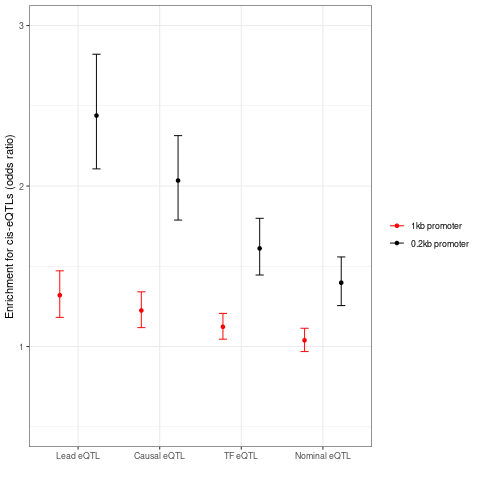

In [7]:
%%R
library(ggplot2)
setwd("/disk2/G4_MS/eQTL")
tss <- read.csv("tss_pG4.eqtl.result.csv",header=T,row.names = 1)
row.names(tss) <- c("Lead eQTL","Causal eQTL","Nominal eQTL","TF eQTL")
tss_result <- as.data.frame(rbind(apply(tss,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$estimate[[1]]),
apply(tss,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$conf.int),
apply(tss,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$p.value)))
row.names(tss_result) <- c("odds_ratio","confidence_down","confidence_up","pvalue")
tss_result <- as.data.frame(t(tss_result))
tss_result$groups <- factor(rownames(tss_result),level=c("Lead eQTL","Causal eQTL","TF eQTL","Nominal eQTL"))
tss_result$fills <- "1kb promoter"
      
eg4 <- read.csv("H3k4me3_pG4.eqtl.result.csv",header=T,row.names = 1)
row.names(eg4) <- c("Lead eQTL","Causal eQTL","Nominal eQTL","TF eQTL")
eg4_result <- as.data.frame(rbind(apply(eg4,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$estimate[[1]]),
apply(eg4,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$conf.int),
apply(eg4,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$p.value)))
row.names(eg4_result) <- c("odds_ratio","confidence_down","confidence_up","pvalue")
eg4_result <- as.data.frame(t(eg4_result))
eg4_result$groups <- factor(rownames(eg4_result),level=c("Lead eQTL","Causal eQTL","TF eQTL","Nominal eQTL"))
eg4_result$fills <- "0.2kb promoter"
df <- rbind(tss_result,eg4_result)
df$fills <- factor(df$fills,level=c("1kb promoter","0.2kb promoter"))
ggplot(df,aes(x=groups,y=odds_ratio,color=fills,fill=fills))+ geom_point(size = 1.5, position = position_dodge(0.9))+
    geom_errorbar(aes(ymin=confidence_down,ymax=confidence_up),width = 0.2, alpha = 0.9, size = 0.5,position = position_dodge(0.9))+
    theme_bw() + labs(fill="",color="")+
    ylab("Enrichment for cis-eQTLs (odds ratio)") +  scale_color_manual(values=c("red","black")) +
    ylim(0.5,3) + xlab('')
# ggsave("enrich_eQTLs.pdf",width=6,height=8)
# write.table(df,"enrich_eQTLs.tsv",sep="\t")

## eQTL G-tracts analysis
### Fig 6b

In [ ]:
# eqtl noG4
import pyranges as pr
import pandas as pd
import numpy as np
import os
import gzip
import logging
from itertools import groupby

import warnings
warnings.filterwarnings("ignore")

def file_check(path):
    if not os.path.isfile(path):
        log().error("{file} is not exist !!!".format(file=path))
        sys.exit(1)
        
def log():
    logger = logging.getLogger("eQTL")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger

class AFC_get():
    def __init__(self,pG4path,promoter_path,eqtl_path):
        self.pG4_path = pG4path
        self.promoter_path = promoter_path
        self.eqtl_path = eqtl_path
#         self.promoter_path = promoter_path
    def gene_id_filter(self,cds):

    ## differenter regions of promoter identified 
        self.promoter = pr.PyRanges(pd.read_table(self.promoter_path)).subtract(cds, strandedness=False).subset(lambda df:df.Chromosome != "chrY")
        self.pG4 = pr.PyRanges(pd.read_table(self.pG4_path)).subtract(cds, strandedness=False).subset(lambda df:df.Chromosome != "chrY")
        self.non_pG4 = self.promoter[self.promoter.transcript_id.isin(self.pG4.transcript_id)].subtract(self.pG4,strandedness=False).subtract(cds,strandedness=False)

        self.pG4.transcript_id = self.pG4.transcript_id.map(lambda x:x.split(".")[0])
        self.pG4.gene_id = self.pG4.gene_id.map(lambda x:x.split(".")[0])

        ## non G4 
        self.non_pG4.transcript_id = self.non_pG4.transcript_id.map(lambda x:x.split(".")[0])
        self.non_pG4.gene_id = self.non_pG4.gene_id.map(lambda x:x.split(".")[0])
        ## eqtl
        self.eqtl = pr.PyRanges(pd.read_table(self.eqtl_path))
        self.eqtl.gene_id = self.eqtl.gene_id.map(lambda x:x.split(".")[0])
        
        self.pG4_stable = self.pG4[self.pG4.Score > 19]
        self.pG4_unstable = self.pG4[self.pG4.Score < 19]
        
    @staticmethod
    def Gtract_filter(seq, plus=True):
        result = []
        ggg = []
        seqindex = []
        for index, val in enumerate(list(seq)):
            if plus:
                if val == 'g' or val == 'G':
                    ggg.append(index)
            else:
                if val == 'c' or val == 'C':
                    ggg.append(index)
        for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
            _ = [j for i, j in g]
            if len(_) >= 3:
                seqindex.append(_)
        if len(seqindex) > 0:
            for idx in seqindex:
                result.append((idx[0], idx[-1] + 1))
        return result
    
    @staticmethod
    def Gtract_get(df):
        result = []
        df = df.as_df().iloc[:,[0,1,2,3,4,5,6]]
        df = df.drop_duplicates()
        for index, row in df.iterrows():
            plusflg = True
            if row.Strand == "-": plusflg = False
            tp_track = AFC_get.Gtract_filter(row.Name, plus=plusflg)
            gtract_count = 0
            while gtract_count < len(tp_track):
                gtract_index = tp_track[gtract_count]
                if plusflg:
                    stem = [row.Chromosome] + [int(row.Start) + gtract_index[0], int(row.Start)+gtract_index[1]] + ["+"]
                else:
                    stem = [row.Chromosome] + [int(row.Start) + gtract_index[0], int(row.Start)+gtract_index[1]] + ["-"]
                gtract_count += 1
                result.append(stem)
        return pr.PyRanges(pd.DataFrame(result, columns=["Chromosome","Start","End","Strand"]))
                
        
    def eQTL(self, all_snp,gruns,non_pG4=False):
        if not non_pG4:
            non_pG4 = self.non_pG4
        pG4_gruns = AFC_get.Gtract_get(self.pG4)
        pG4_eqtl = self.eqtl.join(self.pG4,strandedness = False,suffix="_c")
        pG4_eqtl = pG4_eqtl[pG4_eqtl.gene_id==pG4_eqtl.gene_id_c]
        pG4_eqtl = pG4_eqtl.overlap(pG4_gruns)
        
        non_pG4_eqtl = self.eqtl.join(non_pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
        non_pG4_eqtl = non_pG4_eqtl[non_pG4_eqtl.gene_id==non_pG4_eqtl.gene_id_c]
        non_pG4_eqtl = non_pG4_eqtl.overlap(gruns)
        pG4_bg = all_snp.join(self.pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
#         pG4_bg = pG4_bg.overlap(self.eqtl,strandedness = False,invert=True)
        pG4_bg = pG4_bg.overlap(pG4_gruns)
        non_pG4_bg = all_snp.overlap(non_pG4,strandedness=False)
#         non_pG4_bg = non_pG4_bg.overlap(self.eqtl,strandedness = False,invert=True)
        non_pG4_bg = non_pG4_bg.overlap(gruns)
        self.result = np.array([pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                pG4_bg.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_bg.drop_duplicate_positions(strand=False).__len__()
                               ]
                              )
        self.eqtl = self.eqtl.overlap(pG4_gruns)
        pG4_eqtl_stable = self.eqtl.join(self.pG4_stable,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_stable = pG4_eqtl_stable[pG4_eqtl_stable.gene_id == pG4_eqtl_stable.gene_id_c]
        pG4_bg_stable = pG4_bg.join(self.pG4_stable,strandedness = False,apply_strand_suffix=False,suffix="_c")
#         pG4_bg_stable = pG4_bg_stable.overlap(self.eqtl,strandedness = False,invert=True)
        self.stable_result = np.array([pG4_eqtl_stable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                pG4_bg_stable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_bg.drop_duplicate_positions(strand=False).__len__()
                               ]
                              )
        pG4_eqtl_unstable = self.eqtl.join(self.pG4_unstable,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_unstable = pG4_eqtl_unstable[pG4_eqtl_unstable.gene_id==pG4_eqtl_unstable.gene_id_c]
        pG4_bg_unstable = pG4_bg.join(self.pG4_unstable,strandedness = False,apply_strand_suffix=False,suffix="_c")
#         pG4_bg_unstable = pG4_bg_unstable.overlap(self.eqtl,strandedness = False,invert=True)
        self.unstable_result = np.array([pG4_eqtl_unstable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_eqtl.drop_duplicate_positions(strand=False).__len__(),
                                pG4_bg_unstable.drop_duplicate_positions(strand=False).__len__(),
                                non_pG4_bg.drop_duplicate_positions(strand=False).__len__()
                               ]
                              )

        
    
#### 
logger = log()
data_path = "/disk2/G4_MS/eQTL/data"
wdpath = "/disk2/G4_MS/eQTL"
gruns_path = os.path.join(data_path,"promoter_gruns.bed")
logger.info("TSS Start")
promoter_path = os.path.join(os.path.dirname(wdpath),"promoter_select","promoter_info")
tss_pG4_path = os.path.join(promoter_path,"promoter_pG4.info.tsv")
tss_nonPG4_path = os.path.join(promoter_path,"promoter_nopG4.info.tsv")
tss_promoter_path = os.path.join(promoter_path,"promoter.annotion.tsv")
h3k4me3_promoter_path = os.path.join(promoter_path,"promoter_info.annotion.H3K4me3.tsv")

h3k4me3_G4_path = os.path.join(promoter_path,"promoter_pG4.info.H3K4me3.tsv")
hek4me4_nonG4_path = os.path.join(promoter_path,"promoter_nopG4.info.H3K4me3.tsv")
cds_path = os.path.join(data_path,"cds.bed")
## eqtl path
lev_eqtl = os.path.join(data_path,"lev.per.gene.tsv.gz")
nominally_eqtl = os.path.join(data_path,"nominally.per.gene.tsv.gz")
causal_eqtl = os.path.join(data_path,"causal.eqtls.info.tsv.gz")
tf_eqtl = os.path.join(data_path,"TF.eqtls.info.tsv.gz")


all_snp_path = os.path.join(data_path,"GTEx_Analysis_v8_all.snp.MAF001.bed.gz")
all_snp = pr.PyRanges(pd.read_table(all_snp_path,compression="gzip"))
all_snp = all_snp.overlap(pr.PyRanges(pd.read_table(nominally_eqtl)),invert=True)
# all_snp = pr.PyRanges(pd.read_table(all_snp_path,compression="gzip",header=None,names=["Chromosome","Start","End","Ref","Alt","variiation_id", "Variation_numbers","Rs_id","b37_varition_id"]))
cds = pr.read_bed(cds_path)
gruns = pr.PyRanges(pd.read_table(gruns_path,header=None,names=["Chromosome","Start","End","Strand","seq"]))

################ TSS analysis
logger.info("TSS pG4 result get")
# lev 
tss = AFC_get(tss_pG4_path,tss_promoter_path,lev_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp,gruns)
lev_result = tss.result.copy()
lev_stable_result = tss.stable_result.copy()
lev_unstable_result = tss.unstable_result.copy()
del tss
# causal 
tss = AFC_get(tss_pG4_path,tss_promoter_path,causal_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp,gruns)
causal_result = tss.result.copy()
causal_stable_result = tss.stable_result.copy()
causal_unstable_result = tss.unstable_result.copy()
del tss

# TF 
tss = AFC_get(tss_pG4_path,tss_promoter_path,tf_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp,gruns)
TF_result = tss.result.copy()
TF_stable_result = tss.stable_result.copy()
TF_unstable_result = tss.unstable_result.copy()
del tss 

# nominal 
tss = AFC_get(tss_pG4_path,tss_promoter_path,nominally_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(all_snp,gruns)
nominal_result = tss.result.copy()
nominal_stable_result = tss.stable_result.copy()
nominal_unstable_result = tss.unstable_result.copy()



tss_result = pd.DataFrame([lev_result, causal_result, nominal_result,TF_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
tss_result.to_csv(os.path.join(wdpath,"tss_pG4.eqtl.result.gruns.csv"))

tss_stable_result = pd.DataFrame([lev_stable_result, causal_stable_result, nominal_stable_result,TF_stable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
tss_stable_result.to_csv(os.path.join(wdpath,"tss_pG4_stable.eqtl.result.gruns.csv"))

tss_unstable_result = pd.DataFrame([lev_unstable_result, causal_unstable_result, nominal_unstable_result,TF_unstable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
tss_unstable_result.to_csv(os.path.join(wdpath,"tss_pG4_unstable.eqtl.result.gruns.csv"))

logger.info("TSS pG4 result DONE")

################ H3K4me3 analysis
logger.info("H3K4me3 pG4 result get")
# lev 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,lev_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,gruns,non_pG4=tss.non_pG4)
ep_lev_result = ep.result.copy()
ep_lev_stable_result = ep.stable_result.copy()
ep_lev_unstable_result = ep.unstable_result.copy()
del ep
# causal 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,causal_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,gruns,non_pG4=tss.non_pG4)
ep_causal_result = ep.result.copy()
ep_causal_stable_result = ep.stable_result.copy()
ep_causal_unstable_result = ep.unstable_result.copy()
del ep

# nominal 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,nominally_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,gruns,non_pG4=tss.non_pG4)
ep_nominal_result = ep.result.copy()
ep_nominal_stable_result = ep.stable_result.copy()
ep_nominal_unstable_result = ep.unstable_result.copy()
del ep
# TF 
ep = AFC_get(h3k4me3_G4_path,h3k4me3_promoter_path,tf_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(all_snp,gruns,non_pG4=tss.non_pG4)
ep_TF_result = ep.result.copy()
ep_TF_stable_result = ep.stable_result.copy()
ep_TF_unstable_result = ep.unstable_result.copy()
del ep 

ep_result = pd.DataFrame([ep_lev_result, ep_causal_result, ep_nominal_result,ep_TF_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
ep_result.to_csv(os.path.join(wdpath,"H3k4me3_pG4.eqtl.result.gruns.csv"))

ep_stable_result = pd.DataFrame([ep_lev_stable_result, ep_causal_stable_result, ep_nominal_stable_result,ep_TF_stable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
ep_stable_result.to_csv(os.path.join(wdpath,"H3k4me3_pG4.eqtl_stable.result.gruns.csv"))

ep_unstable_result = pd.DataFrame([ep_lev_unstable_result, ep_causal_unstable_result, ep_nominal_unstable_result,ep_TF_unstable_result],
                          columns=["pG4_eQTL", "no_pG4_eQTL", 'pG4_bg', 'no_pG4_bg']
                          )
ep_unstable_result.to_csv(os.path.join(wdpath,"H3k4me3_pG4.eqtl_unstable.result.gruns.csv"))
logger.info("H3k4me3 pG4 result DONE")

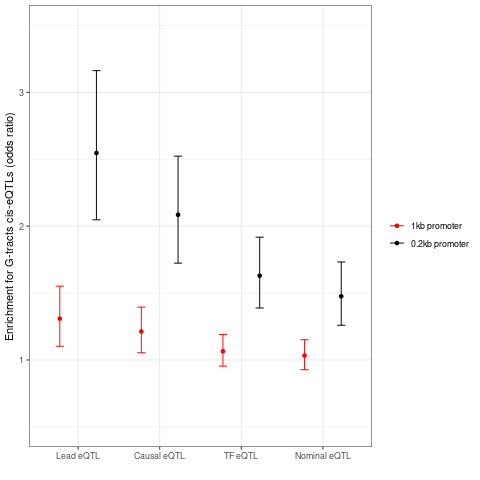

In [9]:
%%R
library(ggplot2)
setwd("/disk2/G4_MS/eQTL")
tss <- read.csv("tss_pG4.eqtl.result.gruns.csv",header=T,row.names = 1)
row.names(tss) <- c("Lead eQTL","Causal eQTL","Nominal eQTL","TF eQTL")
tss_result <- as.data.frame(rbind(apply(tss,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$estimate[[1]]),
apply(tss,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$conf.int),
apply(tss,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$p.value)))
row.names(tss_result) <- c("odds_ratio","confidence_down","confidence_up","pvalue")
tss_result <- as.data.frame(t(tss_result))
tss_result$groups <- factor(rownames(tss_result),level=c("Lead eQTL","Causal eQTL","TF eQTL","Nominal eQTL"))
tss_result$fills <- "1kb promoter"
      
eg4 <- read.csv("H3k4me3_pG4.eqtl.result.gruns.csv",header=T,row.names = 1)
row.names(eg4) <- c("Lead eQTL","Causal eQTL","Nominal eQTL","TF eQTL")
eg4_result <- as.data.frame(rbind(apply(eg4,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$estimate[[1]]),
apply(eg4,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$conf.int),
apply(eg4,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$p.value)))
row.names(eg4_result) <- c("odds_ratio","confidence_down","confidence_up","pvalue")
eg4_result <- as.data.frame(t(eg4_result))
eg4_result$groups <- factor(rownames(eg4_result),level=c("Lead eQTL","Causal eQTL","TF eQTL","Nominal eQTL"))
eg4_result$fills <- "0.2kb promoter"
df <- rbind(tss_result,eg4_result)
df$fills <- factor(df$fills,level=c("1kb promoter","0.2kb promoter"))
ggplot(df,aes(x=groups,y=odds_ratio,color=fills,fill=fills))+ geom_point(size = 1.5, position = position_dodge(0.9))+
    geom_errorbar(aes(ymin=confidence_down,ymax=confidence_up),width = 0.2, alpha = 0.9, size = 0.5,position = position_dodge(0.9))+
    theme_bw() + labs(fill="",color="")+
    ylab("Enrichment for G-tracts cis-eQTLs (odds ratio)") +  scale_color_manual(values=c("red","black")) +
    ylim(0.5,3.5) + xlab('')
# ggsave("enrich_eQTLs.gruns.pdf",width=8,height=7)
# write.table(df,"enrich_eQTLs.gruns.tsv",sep="\t")

## TF bingSite analysis
#### Fig 6c

In [ ]:
%%R
library(GenomicRanges)
library(dplyr)
library(ChIPseeker)

# TF Binding site analysis
setwd("/disk2/G4_MS/transcript/TFB_sites")
txdb.filename <- "/disk2/project/g_quadruplex/MAPS/Homo_sapiens.GRCh38.104.sqlite"

txdb <- ensembldb::EnsDb(txdb.filename)

# clinvar_genes <- AnnotationDbi::mapIds(txdb,
#                                        keys=gsub(pattern = ":.*","",clinvar_genes$GENEINFO),
#                                        column = "GENEID",keytype="SYMBOL")
TFdata.path <- "/disk2/G4_MS/transcript/TFB_sites"
tss_K562.path <- file.path(TFdata.path,"tss_K562.chip.bed")
tss_K562 <- data.table::fread(tss_K562.path)
tss_HepG2.path <- file.path(TFdata.path,"tss_HepG2.chip.bed")
tss_HepG2 <- data.table::fread(tss_HepG2.path)

colnames(tss_K562) <- c('chromosome','start','end','chip_gene_symbol',"cell_type","strand","promoter_chromosome","promoter_start","promoter_end",
                       "promoter_id","gene_id","promoter_strand","transcript_id","gene_name")
colnames(tss_HepG2) <- c('chromosome','start','end','chip_gene_symbol',"cell_type","strand","promoter_chromosome","promoter_start","promoter_end",
                       "promoter_id","gene_id","promoter_strand","transcript_id","gene_name")
tss_promoter_G4 <- data.table::fread("/disk2/G4_MS/promoter_select/promoter_info/promoter_pG4.info.tsv",header=T)
tss_promoter_G4 <- makeGRangesFromDataFrame(tss_promoter_G4,keep.extra.columns=TRUE,
                                        seqnames.field = "Chromosome",
                                         start.field = "Start",
                                         end.field = "End",
                                         strand.field = "Strand"
                                        )
tss_promoter_nonG4 <- data.table::fread("/disk2/G4_MS/promoter_select/promoter_info/promoter_nopG4.info.tsv")
tss_promoter_nonG4 <- makeGRangesFromDataFrame(tss_promoter_nonG4,keep.extra.columns=TRUE,
                                        seqnames.field = "Chromosome",
                                         start.field = "Start",
                                         end.field = "End",
                                         strand.field = "Strand"
                                        )
tss_grange <- makeGRangesFromDataFrame(rbind(tss_K562,tss_HepG2),
                                           keep.extra.columns = TRUE,
                                           seqnames.field = 'chromosome',
                                           start.field = 'start',
                                           end.field = 'end',
                                           strand.field = 'strand')

h3k4me3_K562.path <- file.path(TFdata.path,"h3k4me3_K562.chip.bed")
h3k4me3_K562 <- data.table::fread(h3k4me3_K562.path)
colnames(h3k4me3_K562) <- c('chromosome','start','end','chip_gene_symbol',"cell_type","strand","promoter_chromosome","promoter_start","promoter_end",
                       "promoter_id","gene_id","promoter_strand", "transcript_id", "gene_type", "gene_name", "oriPrmtrStart","oriPrmtrEnd")
h3k4me3_HepG2.path <- file.path(TFdata.path,"h3k4me3_HepG2.chip.bed")
h3k4me3_HepG2 <- data.table::fread(h3k4me3_HepG2.path)
colnames(h3k4me3_HepG2) <- c('chromosome','start','end','chip_gene_symbol',"cell_type","strand","promoter_chromosome","promoter_start","promoter_end",
                       "promoter_id","gene_id","promoter_strand", "transcript_id", "gene_type", "gene_name", "oriPrmtrStart","oriPrmtrEnd")

h3k4me3_promoter_G4 <- data.table::fread("/disk2/G4_MS/promoter_select/promoter_info/promoter_pG4.info.H3K4me3.tsv",header=T)
h3k4me3_promoter_G4 <- makeGRangesFromDataFrame(h3k4me3_promoter_G4,keep.extra.columns=TRUE,
                                        seqnames.field = "Chromosome",
                                         start.field = "Start",
                                         end.field = "End",
                                         strand.field = "Strand"
                                        )
h3k4me3_promoter_nonG4 <- data.table::fread("/disk2/G4_MS/promoter_select/promoter_info/promoter_nopG4.info.H3K4me3.tsv")
h3k4me3_promoter_nonG4 <- makeGRangesFromDataFrame(h3k4me3_promoter_nonG4,keep.extra.columns=TRUE,
                                        seqnames.field = "Chromosome",
                                         start.field = "Start",
                                         end.field = "End",
                                         strand.field = "Strand"
                                        )
h3k4me3_grange <- makeGRangesFromDataFrame(rbind(h3k4me3_K562,h3k4me3_HepG2),
                                           keep.extra.columns = TRUE,
                                           seqnames.field = 'chromosome',
                                           start.field = 'start',
                                           end.field = 'end',
                                           strand.field = 'strand')
###
g4_h3k4me3_tfbs <- subsetByOverlaps(h3k4me3_grange, h3k4me3_promoter_G4)
nong4_h3k4me3_tfbs <- subsetByOverlaps(h3k4me3_grange, h3k4me3_promoter_nonG4)
h3k4me3_genes <- c(g4_h3k4me3_tfbs$gene_id, nong4_h3k4me3_tfbs$gene_id)

g4_tss_tfbs <- subsetByOverlaps(tss_grange, tss_promoter_G4)
nong4_tss_tfbs <- subsetByOverlaps(tss_grange, tss_promoter_nonG4)
tss_genes <- c(g4_tss_tfbs$gene_id, nong4_tss_tfbs$gene_id)


g4_h3k4me3_ppb <- length(reduce(g4_h3k4me3_tfbs))/sum(width(reduce(h3k4me3_promoter_G4[h3k4me3_promoter_G4$gene_id %in% h3k4me3_genes, ])))
nog4_h3k4me3_ppb <- length(reduce(nong4_h3k4me3_tfbs))/sum(width(reduce(h3k4me3_promoter_nonG4[h3k4me3_promoter_nonG4$gene_id %in% h3k4me3_genes, ])))

g4_tss_ppb <- length(reduce(g4_tss_tfbs))/sum(width(reduce(tss_promoter_G4[tss_promoter_G4$gene_id %in% tss_genes, ])))
nog4_tss_ppb <- length(reduce(nong4_tss_tfbs))/sum(width(reduce(tss_promoter_nonG4[tss_promoter_nonG4$gene_id %in% tss_genes, ])))

###########
tss_mat <- matrix(c(length(reduce(g4_tss_tfbs)),
                     sum(width(reduce(tss_promoter_G4[tss_promoter_G4$gene_id %in% tss_genes, ]))),
                     length(reduce(nong4_tss_tfbs)),
                     sum(width(reduce(tss_promoter_nonG4[tss_promoter_nonG4$gene_id %in% tss_genes, ])))), nrow = 2)
print(prop.test(tss_mat))

h3k4me3_mat <- matrix(c(length(reduce(g4_h3k4me3_tfbs)),
                     sum(width(reduce(h3k4me3_promoter_G4[h3k4me3_promoter_G4$gene_id %in% h3k4me3_genes, ]))),
                     length(reduce(nong4_tss_tfbs)),
                     sum(width(reduce(h3k4me3_promoter_nonG4[h3k4me3_promoter_nonG4$gene_id %in% h3k4me3_genes, ])))), nrow = 2)
print(prop.test(h3k4me3_mat))

promoter_pb_tfps <- c(g4_tss_ppb,
                 nog4_tss_ppb,
                 g4_h3k4me3_ppb,
                 nog4_h3k4me3_ppb) * 1000

pdf('Transcript_factor_binding.region.pdf')
par(mgp=c(2.5,1,0))
tfps_freq <- barplot(matrix(promoter_pb_tfps, nr=2), beside = TRUE,
                     col = c("aquamarine3", "coral"),
                     names.arg = c("",
                                   "",
                                   "",
                                   ""),
                     xlab = "",
                     ylab = expression(paste("TF binding locations per KB")),
                     main = "",
                     ylim = c(0, 20))
text(x = tfps_freq, y = promoter_pb_tfps, label = round(promoter_pb_tfps, 3), pos = 3, cex = 0.8)
axis(1, at=c(2,5), labels=c("Promoter","Active promoter"), tick = FALSE)
legend('topleft',
       legend=c("pG4", "non-pG4"),
       fill= c('aquamarine3', 'coral'),
       cex = 0.8)
par(mgp=c(3,1,0))
dev.off()

# eff analysis
## used eqtls  repressioned mutation eff, activate or repress mRNA express

### Fig 6d


In [ ]:
import pandas as pd
import pyranges as pr
import os,sys
import numpy as np

def eff_trans(x):
    df = x.sort_values(by = 'slope',ascending=True)
    if df.iloc[0,10]> 0:
        return df.iloc[0,[0,1,2,3,4,5,10]]
    else:
        if df.iloc[-1,10] > 0:
            df.iloc[0,10] = np.NaN
            return df.iloc[0,[0,1,2,3,4,5,10]]
        else:
            return df.iloc[0,[0,1,2,3,4,5,10]]
        
class AFC_get():
    def __init__(self,pG4path,promoter_path,eqtl_path):
        self.pG4_path = pG4path
        self.promoter_path = promoter_path
        self.eqtl_path = eqtl_path
    @staticmethod
    def Gtract_filter(seq, plus=True):
        result = []
        ggg = []
        seqindex = []
        for index, val in enumerate(list(seq)):
            if plus:
                if val == 'g' or val == 'G':
                    ggg.append(index)
            else:
                if val == 'c' or val == 'C':
                    ggg.append(index)
        for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
            _ = [j for i, j in g]
            if len(_) >= 3:
                seqindex.append(_)
        if len(seqindex) > 0:
            for idx in seqindex:
                result.append((idx[0], idx[-1] + 1))
        return result
    
    @staticmethod
    def Gtract_get(df):
        result = []
        df = df.as_df().iloc[:,[0,1,2,3,4,5,6]]
        df = df.drop_duplicates()
        for index, row in df.iterrows():
            plusflg = True
            if row.Strand == "-": plusflg = False
            tp_track = AFC_get.Gtract_filter(row.Name, plus=plusflg)
            gtract_count = 0
            while gtract_count < len(tp_track):
                gtract_index = tp_track[gtract_count]
                if plusflg:
                    stem = [row.Chromosome] + [int(row.Start) + gtract_index[0], int(row.Start)+gtract_index[1]] + ["+"]
                else:
                    stem = [row.Chromosome] + [int(row.Start) + gtract_index[0], int(row.Start)+gtract_index[1]] + ["-"]
                gtract_count += 1
                result.append(stem)
        return pr.PyRanges(pd.DataFrame(result, columns=["Chromosome","Start","End","Strand"]))
    def gene_id_filter(self,cds):
        ## differenter regions of promoter identified 
        self.promoter = pr.PyRanges(pd.read_table(self.promoter_path)).subtract(cds, strandedness=False).subset(lambda df:df.Chromosome != "chrY")
        self.pG4 = pr.PyRanges(pd.read_table(self.pG4_path)).subtract(cds, strandedness=False).subset(lambda df:df.Chromosome != "chrY")
        self.non_pG4 = self.promoter[self.promoter.transcript_id.isin(self.pG4.transcript_id)].subtract(self.pG4,strandedness=False).subtract(cds,strandedness=False)
        
        self.pG4.transcript_id = self.pG4.transcript_id.map(lambda x:x.split(".")[0])
        self.pG4.gene_id = self.pG4.gene_id.map(lambda x:x.split(".")[0])
        
        ## non G4 
        self.non_pG4.transcript_id = self.non_pG4.transcript_id.map(lambda x:x.split(".")[0])
        self.non_pG4.gene_id = self.non_pG4.gene_id.map(lambda x:x.split(".")[0])
        ## eqtl
        self.eqtl = pr.PyRanges(pd.read_table(self.eqtl_path))
        self.eqtl.gene_id = self.eqtl.gene_id.map(lambda x:x.split(".")[0])
        
        self.pG4_stable = self.pG4[self.pG4.Score > 19]
        self.pG4_unstable = self.pG4[self.pG4.Score <= 19]
        self.pG4_gpqs = self.pG4[self.pG4.g4_class.isin(["GPQS"])]
        self.pG4_cpqs = self.pG4[self.pG4.g4_class.isin(["CPQS"])]
        
    def eQTL(self, gruns, non_pG4=False):
        if not non_pG4:
            non_pG4 = self.non_pG4
        pG4_gruns = AFC_get.Gtract_get(self.pG4)
        
        pG4_eqtl = self.eqtl.join(self.pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl = pG4_eqtl[pG4_eqtl.gene_id==pG4_eqtl.gene_id_c]
        pG4_eqtl_gruns = pG4_eqtl.overlap(pG4_gruns)
        pG4_eqtl_gruns_up = pG4_eqtl_gruns[pG4_eqtl_gruns.slope > 0].__len__()
        pG4_eqtl_gruns_down = pG4_eqtl_gruns[pG4_eqtl_gruns.slope < 0].__len__()
        
        pG4_eqtl_nongruns = pG4_eqtl.overlap(pG4_gruns,invert=True)
        pG4_eqtl_nongruns_up = pG4_eqtl_nongruns[pG4_eqtl_nongruns.slope > 0].__len__()
        pG4_eqtl_nongruns_down = pG4_eqtl_nongruns[pG4_eqtl_nongruns.slope < 0].__len__()
        
        non_pG4_eqtl = self.eqtl.join(non_pG4,strandedness = False,apply_strand_suffix=False,suffix="_c")
        non_pG4_eqtl = non_pG4_eqtl[non_pG4_eqtl.gene_id==non_pG4_eqtl.gene_id_c]
        
        non_pG4_eqtl_gruns = non_pG4_eqtl.overlap(gruns)
        non_pG4_eqtl_gruns_up = non_pG4_eqtl_gruns[non_pG4_eqtl_gruns.slope > 0].__len__()
        non_pG4_eqtl_gruns_down = non_pG4_eqtl_gruns[non_pG4_eqtl_gruns.slope < 0].__len__()
        
        non_pG4_eqtl_nongruns = non_pG4_eqtl.overlap(gruns,invert=True)
        non_pG4_eqtl_nongruns_up = non_pG4_eqtl_nongruns[non_pG4_eqtl_nongruns.slope > 0].__len__()
        non_pG4_eqtl_nongruns_down = non_pG4_eqtl_nongruns[non_pG4_eqtl_nongruns.slope < 0].__len__()
        
        
        self.pG4_result = np.array([pG4_eqtl_gruns_up,
                                pG4_eqtl_gruns_down,
                                pG4_eqtl_nongruns_up,
                                pG4_eqtl_nongruns_down
                               ]
                              )
        self.nonpG4_result = np.array([non_pG4_eqtl_gruns_up,
                                non_pG4_eqtl_gruns_down,
                                non_pG4_eqtl_nongruns_up,
                                non_pG4_eqtl_nongruns_down
                               ]
                              )        
        pG4_eqtl_stable = self.eqtl.join(self.pG4_stable,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_stable = pG4_eqtl_stable[pG4_eqtl_stable.gene_id==pG4_eqtl_stable.gene_id_c]
        
        pG4_eqtl_stable_gruns = pG4_eqtl_stable.overlap(pG4_gruns)
        pG4_eqtl_stable_gruns_up = pG4_eqtl_stable_gruns[pG4_eqtl_stable_gruns.slope > 0].__len__()
        pG4_eqtl_stable_gruns_down = pG4_eqtl_stable_gruns[pG4_eqtl_stable_gruns.slope < 0].__len__()
        
        pG4_eqtl_stable_nongruns = pG4_eqtl_stable.overlap(pG4_gruns,invert=True)
        pG4_eqtl_stable_nongruns_up = pG4_eqtl_stable_nongruns[pG4_eqtl_stable_nongruns.slope > 0].__len__()
        pG4_eqtl_stable_nongruns_down = pG4_eqtl_stable_nongruns[pG4_eqtl_stable_nongruns.slope < 0].__len__()
        self.stable_result = np.array([pG4_eqtl_stable_gruns_up,
                                pG4_eqtl_stable_gruns_down,
                                pG4_eqtl_stable_nongruns_up,
                                pG4_eqtl_stable_nongruns_down
                               ]
                              )
        
        pG4_eqtl_unstable = self.eqtl.join(self.pG4_unstable,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_unstable = pG4_eqtl_unstable[pG4_eqtl_unstable.gene_id==pG4_eqtl_unstable.gene_id_c]
        
        pG4_eqtl_unstable_gruns = pG4_eqtl_unstable.overlap(pG4_gruns)
        pG4_eqtl_unstable_up = pG4_eqtl_unstable_gruns[pG4_eqtl_unstable_gruns.slope > 0].__len__()
        pG4_eqtl_unstable_down = pG4_eqtl_unstable_gruns[pG4_eqtl_unstable_gruns.slope < 0].__len__()
        
        pG4_eqtl_unstable_nongruns = pG4_eqtl_unstable.overlap(pG4_gruns,invert=True)
        pG4_eqtl_unstable_nongruns_up = pG4_eqtl_unstable_nongruns[pG4_eqtl_unstable_nongruns.slope > 0].__len__()
        pG4_eqtl_unstable_nongruns_down = pG4_eqtl_unstable_nongruns[pG4_eqtl_unstable_nongruns.slope < 0].__len__()
        

        self.unstable_result = np.array([pG4_eqtl_unstable_up,
                                pG4_eqtl_unstable_down,
                                pG4_eqtl_unstable_nongruns_up,
                                pG4_eqtl_unstable_nongruns_down
                               ]
                              )
        

        pG4_eqtl_gpqs = self.eqtl.join(self.pG4_gpqs,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_gpqs = pG4_eqtl_gpqs[pG4_eqtl_gpqs.gene_id==pG4_eqtl_gpqs.gene_id_c]
        
        pG4_eqtl_gpqs_gruns = pG4_eqtl_gpqs.overlap(pG4_gruns)
        pG4_eqtl_gpqs_gruns_up = pG4_eqtl_gpqs_gruns[pG4_eqtl_gpqs_gruns.slope > 0].__len__()
        pG4_eqtl_gpqs_gruns_down = pG4_eqtl_gpqs_gruns[pG4_eqtl_gpqs_gruns.slope < 0].__len__()
        
        pG4_eqtl_gpqs_nongruns = pG4_eqtl_gpqs.overlap(pG4_gruns,invert=True)
        pG4_eqtl_gpqs_nongruns_up = pG4_eqtl_gpqs_nongruns[pG4_eqtl_gpqs_nongruns.slope > 0].__len__()
        pG4_eqtl_gpqs_nongruns_down = pG4_eqtl_gpqs_nongruns[pG4_eqtl_gpqs_nongruns.slope < 0].__len__()
        self.gpqs_result = np.array([pG4_eqtl_gpqs_gruns_up,
                                pG4_eqtl_gpqs_gruns_down,
                                pG4_eqtl_gpqs_nongruns_up,
                                pG4_eqtl_gpqs_nongruns_down
                               ]
                              )
        
        pG4_eqtl_cpqs = self.eqtl.join(self.pG4_cpqs,strandedness = False,apply_strand_suffix=False,suffix="_c")
        pG4_eqtl_cpqs = pG4_eqtl_cpqs[pG4_eqtl_cpqs.gene_id==pG4_eqtl_cpqs.gene_id_c]
        
        pG4_eqtl_cpqs_gruns = pG4_eqtl_cpqs.overlap(pG4_gruns)
        pG4_eqtl_cpqs_up = pG4_eqtl_cpqs_gruns[pG4_eqtl_cpqs_gruns.slope > 0].__len__()
        pG4_eqtl_cpqs_down = pG4_eqtl_cpqs_gruns[pG4_eqtl_cpqs_gruns.slope < 0].__len__()
        
        pG4_eqtl_cpqs_nongruns = pG4_eqtl_cpqs.overlap(pG4_gruns,invert=True)
        pG4_eqtl_cpqs_nongruns_up = pG4_eqtl_cpqs_nongruns[pG4_eqtl_cpqs_nongruns.slope > 0].__len__()
        pG4_eqtl_cpqs_nongruns_down = pG4_eqtl_cpqs_nongruns[pG4_eqtl_cpqs_nongruns.slope < 0].__len__()
        

        self.cpqs_result = np.array([pG4_eqtl_cpqs_up,
                                pG4_eqtl_cpqs_down,
                                pG4_eqtl_cpqs_nongruns_up,
                                pG4_eqtl_cpqs_nongruns_down
                               ]
                              )


data_path = "/disk2/G4_MS/eQTL/data"
cds_path = os.path.join(data_path,"cds.bed")
wdpath = "/disk2/G4_MS/eQTL"
gruns_path = os.path.join(data_path,"promoter_gruns.bed")
# nominally_eqtl = os.path.join(data_path,"nominally.per.gene.tsv.gz")
nominally_eqtl = os.path.join(data_path,"nominal_eqtls.tsv")
# pG4
promoter_path = os.path.join(os.path.dirname(wdpath),"promoter_select","promoter_info")
tss_pG4_path = os.path.join(promoter_path,"promoter_pG4.info.tsv")
tss_nonPG4_path = os.path.join(promoter_path,"promoter_nopG4.info.tsv")
h3k4me3_G4_path = os.path.join(promoter_path,"promoter_pG4.info.H3K4me3.tsv")
hek4me4_nonG4_path = os.path.join(promoter_path,"promoter_nopG4.info.H3K4me3.tsv")
tss_promoter_path = os.path.join(promoter_path,"promoter.annotion.tsv")
h3k4me3_promoter_path = os.path.join(promoter_path, "promoter_info.annotion.H3K4me3.tsv")
### 
print("Tss analysis Start")
# tss = AFC_get(tss_pG4_path,tss_nonPG4_path, nominally_eqtl)
gruns = pr.PyRanges(pd.read_table(gruns_path,header=None,names=["Chromosome","Start","End","Strand","seq"]))
cds = pr.read_bed(cds_path)

tss = AFC_get(tss_pG4_path, tss_promoter_path, nominally_eqtl)
tss.gene_id_filter(cds)
tss.eQTL(gruns)
tss_pG4_result = tss.pG4_result.copy()
tss_non_pG4_result = tss.nonpG4_result.copy()
tss_stable_result = tss.stable_result.copy()
tss_unstable_result = tss.unstable_result.copy()
tss_gpqs_result = tss.gpqs_result.copy()
tss_cpqs_result = tss.cpqs_result.copy()
tss_result = pd.DataFrame([tss_pG4_result,tss_non_pG4_result,tss_stable_result,tss_unstable_result,tss_gpqs_result,tss_cpqs_result],
                         columns=["pG4_gruns_eff_plus", "pG4_gruns_eff_minus", "pG4_nonGruns_eff_plus","pG4_nonGruns_eff_minus"]
                         )
tss_result.to_csv(os.path.join(wdpath,"tss_pG4.G_tracts_loops.eff.csv"))

ep = AFC_get(h3k4me3_G4_path, h3k4me3_promoter_path, nominally_eqtl)
ep.gene_id_filter(cds)
ep.eQTL(gruns)
ep_pG4_result = ep.pG4_result.copy()
ep_non_pG4_result = ep.nonpG4_result.copy()
ep_stable_result = ep.stable_result.copy()
ep_unstable_result = ep.unstable_result.copy()
ep_gpqs_result = ep.gpqs_result.copy()
ep_cpqs_result = ep.cpqs_result.copy()

ep_result = pd.DataFrame([ep_pG4_result,ep_non_pG4_result,ep_stable_result,ep_unstable_result,ep_gpqs_result,ep_cpqs_result],
                         columns=["pG4_gruns_eff_plus", "pG4_gruns_eff_minus", "pG4_nonGruns_eff_plus","pG4_nonGruns_eff_minus"]
                         )
ep_result.to_csv(os.path.join(wdpath,"h3k4me3_pG4.G_tracts_loops.eff.csv"))

R[write to console]: 
载入程辑包：‘gridExtra’


R[write to console]: The following object is masked from ‘package:BiocGenerics’:

    combine


R[write to console]: 
载入程辑包：‘dplyr’


R[write to console]: The following object is masked from ‘package:gridExtra’:

    combine


R[write to console]: The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




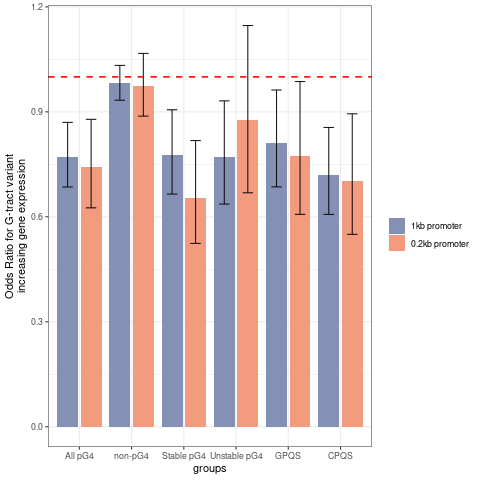

In [11]:
%%R
library(ggplot2)
library(gridExtra)
library(dplyr)
library(ggsci)
library(ggsignif)

setwd("/disk2/G4_MS/eQTL")
tss_result <- read.csv("tss_pG4.G_tracts_loops.eff.csv",header=T)
tss_result <- tss_result[-1]
tss_result <- dplyr::select(tss_result, pG4_gruns_eff_plus, pG4_gruns_eff_minus, pG4_nonGruns_eff_plus, pG4_nonGruns_eff_minus )
row.names(tss_result) <- c("All pG4","non-pG4", "Stable pG4","Unstable pG4","GPQS","CPQS")
tss_result <- as.data.frame(rbind(apply(tss_result,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$estimate[[1]]),
apply(tss_result,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$conf.int),
apply(tss_result,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$p.value)))
row.names(tss_result) <- c("odds_ratio","confidence_down","confidence_up","pvalue")
tss_result <- as.data.frame(t(tss_result))
tss_result$groups <- factor(rownames(tss_result),level=c("All pG4","non-pG4","Stable pG4","Unstable pG4","GPQS","CPQS"))
tss_result$fills <- "1kb promoter"
      
ep_result <- read.csv("h3k4me3_pG4.G_tracts_loops.eff.csv",header=T)
ep_result <- ep_result[-1]
ep_result <- dplyr::select(ep_result, pG4_gruns_eff_plus, pG4_gruns_eff_minus, pG4_nonGruns_eff_plus, pG4_nonGruns_eff_minus )
row.names(ep_result) <- c("All pG4","non-pG4","Stable pG4","Unstable pG4","GPQS","CPQS")
eg4_result <- as.data.frame(rbind(apply(ep_result,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$estimate[[1]]),
apply(ep_result,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$conf.int),
apply(ep_result,1,function(x) fisher.test(matrix(c(x),ncol = 2,nrow = 2))$p.value)))
row.names(eg4_result) <- c("odds_ratio","confidence_down","confidence_up","pvalue")
eg4_result <- as.data.frame(t(eg4_result))
eg4_result$groups <- factor(rownames(eg4_result),level=c("All pG4","non-pG4","Stable pG4","Unstable pG4","GPQS","CPQS"))
eg4_result$fills <- "0.2kb promoter"
df <- rbind(tss_result,eg4_result)
df$fills <- factor(df$fills, level=c("1kb promoter","0.2kb promoter"))
# df$fills <- factor(df$fills, level=c("Entire promoter","Active promoter"))     
write.table(df,"Merge_Stable_Unstable_GPQS_CPQS_G4_gruns.loops.eff.tsv",sep="\t")

p <- ggplot(df,aes(x=groups,y=odds_ratio,fill=fills))+ geom_bar(stat = "identity", position = position_dodge(0.9), width = 0.8)+
geom_errorbar(aes(ymin=confidence_down,ymax=confidence_up),width = 0.4, alpha = 0.9, size = 0.5,position = position_dodge(0.9))+
 theme_bw() + labs(fill="",color="")+geom_hline(yintercept = 1, color = 'red', lty = 2, lwd = 0.75)+
 ylab("Odds Ratio for G-tract variant\nincreasing gene expression") +  scale_color_manual(values=c("black", "black"))+
# scale_fill_manual(values=c("#E64B35FF","#4DBBD5FF","grey", "#00A087FF", "#3C5488FF","grey", "#F39B7FFF", "#8491B4FF"))
# ylim(0,1.45)+
scale_fill_manual(values=c( "#8491B4FF","#F39B7FFF"))
      
grid.arrange(p)
G <- arrangeGrob(p)
ggsave("Merge_Stable_Unstable_GPQS_CPQS_G4_gruns.loops.eff.tsv_new.pdf",G,width=10,height=4)
